In [1]:
import numpy as np
import matplotlib
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os, sys
import cv2
from PIL import Image
from matplotlib.pyplot import imshow
from skimage.exposure import rescale_intensity, adjust_gamma, equalize_adapthist
from scipy.spatial.transform import Rotation as R
%load_ext autoreload
%autoreload 2

In [14]:
animal = 'DK39'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}'
INPUT = os.path.join(DIR, 'preps', 'CH1', 'thumbnail')
MASK = os.path.join(DIR, 'preps','thumbnail_masked')
ROT_DIR = os.path.join(DIR, 'rotations')
masks = sorted(os.listdir(MASK))
files = sorted(os.listdir(INPUT))
rotations = sorted(os.listdir(ROT_DIR))

In [3]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.utilities_mask import trim_edges, get_binary_mask, fix_with_fill, equalized
from utilities.SqlController import SqlController
sqlController = SqlController(animal)

In [ ]:
theta = np.radians(90)
rmatrix = np.array(( 
    (np.cos(theta), -np.sin(theta), 0),
    (np.sin(theta),  np.cos(theta),0),
    (0,0,1)
))
print('rotation matrix:')
print(rmatrix)
v = np.array((1,2,3))
print('vector v: ')
print(v)
print(f'shape r: {rmatrix.shape} shape v: {v.shape}')
print('apply the rotation matrix r to v: r*v')
print( rmatrix.dot(v) )
rcomp = rmatrix @ rmatrix @ rmatrix @ rmatrix
print(rcomp.dot(v))

In [ ]:
r = R.from_quat([0, 0, np.sin(np.pi/4), np.cos(np.pi/4)])
r.as_euler('xyz', degrees=True)

In [ ]:
r = R.from_matrix(rmatrix)
r.as_euler('xyz', degrees=True)

In [5]:
r = R.from_euler('x', 90, degrees=True)
r.as_matrix()

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.22044605e-16, -1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  2.22044605e-16]])

In [ ]:
filename = '356.tif' 
mask_path = os.path.join(MASK, filename)
infile = os.path.join(INPUT, filename)
img = io.imread(infile)
mask = io.imread(mask_path)
img = cv2.bitwise_and(img, img, mask=mask)
img = equalized(img)
imshow(img, cmap="gray")

In [11]:
infile = os.path.join(INPUT, '181.tif')
img = io.imread(infile)
im1 = Image.fromarray(img)
#T = np.linalg.inv(r)
#im2 = im1.transform((im1.size), Image.AFFINE, r.flatten()[:6], resample=Image.NEAREST)
#imshow(np.asarray(im2), cmap="gray")

In [ ]:
def rot_x(angle,ptx,pty):
    return math.cos(angle)*ptx + math.sin(angle)*pty

def rot_y(angle,ptx,pty):
    return -math.sin(angle)*ptx + math.cos(angle)*pty

angle = math.radians(0)
im = Image.open(infile)
(x,y) = im.size
xextremes = [rot_x(angle,0,0),rot_x(angle,0,y-1),rot_x(angle,x-1,0),rot_x(angle,x-1,y-1)]
yextremes = [rot_y(angle,0,0),rot_y(angle,0,y-1),rot_y(angle,x-1,0),rot_y(angle,x-1,y-1)]
mnx = min(xextremes)
mxx = max(xextremes)
mny = min(yextremes)
mxy = max(yextremes)
T = np.matrix([[math.cos(angle),math.sin(angle),-mnx],[-math.sin(angle),math.cos(angle),-mny],[0,0,1]])
Tinv = np.linalg.inv(T);
Tinvtuple = (Tinv[0,0],Tinv[0,1], Tinv[0,2], Tinv[1,0],Tinv[1,1],Tinv[1,2])
im = im.transform((int(round(mxx-mnx)),int(round((mxy-mny)))),Image.AFFINE,Tinvtuple,resample=Image.NEAREST)
imshow(np.asarray(im), cmap="gray")



/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK39/preps/CH1/thumbnail_aligned/220.tif


Text(0.5, 1.0, 'fixed')

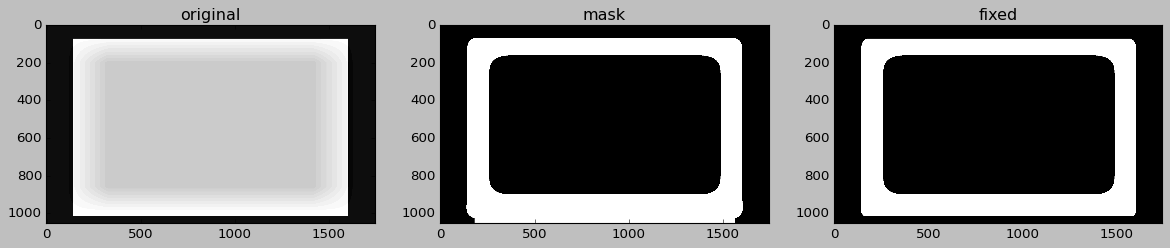

In [10]:
# 181, very dark
# 381, kinda light
file = '220.tif' 
infile = os.path.join(INPUT, file)
print(infile)
img = io.imread(infile)
img = trim_edges(img)
normed = equalized(img)
mask = get_binary_mask(normed)
fixed = cv2.bitwise_and(img, img, mask=mask)
fixed = equalize_adapthist(fixed)
# figure size in inches optional
rcParams['figure.figsize'] = 18 ,18
fig, ax = plt.subplots(1,3)
ax[0].imshow(normed, cmap="gray");
ax[0].set_title('original')
ax[1].imshow(mask, cmap="gray");
ax[1].set_title('mask')
ax[2].imshow(fixed, cmap="gray");
ax[2].set_title('fixed')


100%|██████████| 20/20 [00:02<00:00,  6.82it/s]


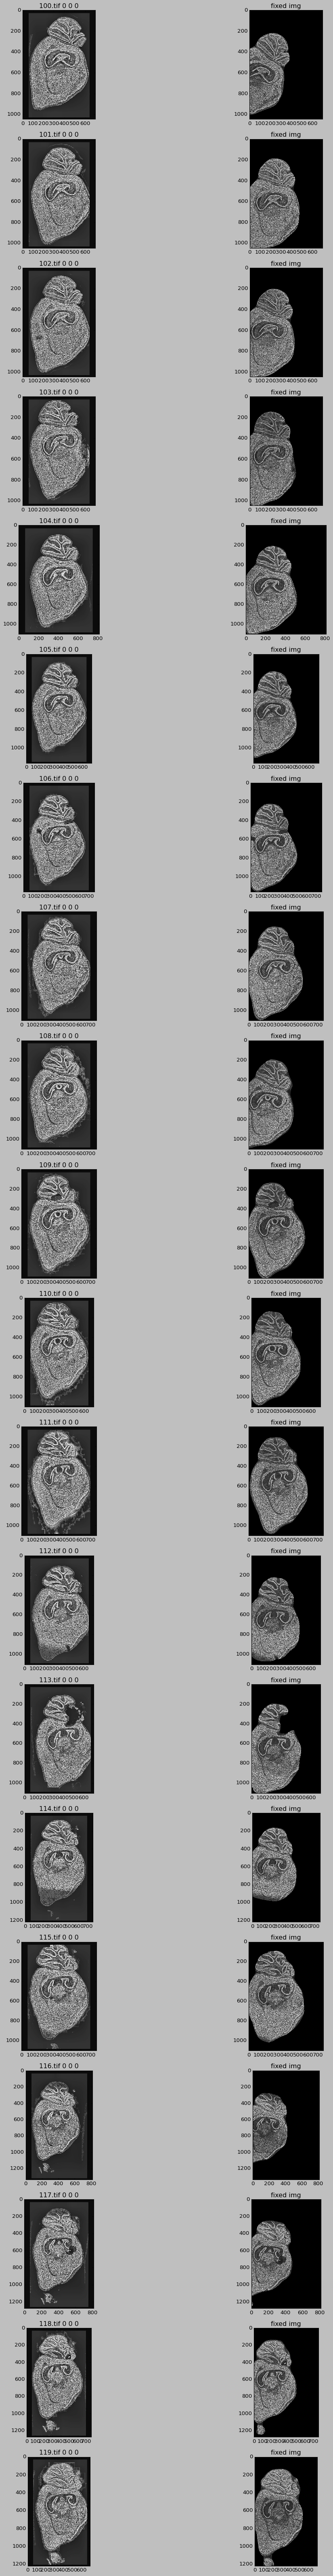

In [36]:
names = []
norms = []
masks = []
fixes = []
start, finish = (100,120)
lowVal, highVal, threshold = (0,0,0)
rot90 = np.array([[0,-1,0],[1,0,0],[0,0,1]])

for file in tqdm(files[start:finish]):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    img = trim_edges(img)
    normed = equalized(img)
    #img8 = (normed/256).astype('uint8')

    norms.append(normed)
    mask = get_binary_mask(img)
    fixed = cv2.bitwise_and(img, img, mask=mask)
    masks.append(mask)    
    name = f'{file} {round(lowVal)} {round(highVal)} {round(threshold)}'
    names.append(name)
    rotfile = file.replace('tif', 'txt')
    rotfile = os.path.join(ROT_DIR, rotfile)
    T = np.loadtxt(rotfile)
    T[0,2] = T[0,2] / 32
    T[1,2] = T[1,2] / 32
    #T[0,2] = 0
    #T[1,2] = 0
    T = np.linalg.inv(T)
    #print(T)
    
    im1 = Image.fromarray(fixed)
    width, height = im1.size
    im2 = im1.transform((im1.size), Image.AFFINE, T.flatten()[:6], resample=Image.NEAREST)
    fixed = np.array(im2)
    
    
    fixes.append(fixed)
    
fig, ax = plt.subplots(nrows=len(names), ncols=2, sharex=False, sharey=False)
plt.style.use('classic')
i = 0
for name, norm, mask, fixed in zip(names, norms, masks, fixes):
    ax[i,0].set_title(f'{name}')
    ax[i,0].imshow(norm, cmap="gray")
    ax[i,1].set_title('fixed img')
    ax[i,1].imshow(fixed, cmap="gray")

    i += 1
fig.set_size_inches(np.array([18, 4 * len(names)]), forward=False)
plt.tight_layout()
plt.show()